# HuBMAP - Hacking the Human Vasculature - EDA
This Kaggle competition can be found at https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/overview . This notebook is an exploratory data analysis conducted on the data given for the competition, which can be found at https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature/data .
Your goal in this competition is to locate microvasculature structures (blood vessels) within human kidney histology slides.


In [1]:
PATH = 'hubmap-hacking-the-human-vasculature/'

In [ ]:
!pip install imagecodecs
!pip install kaleido
!pip install pycocotools


The competition data comprises tiles extracted from five Whole Slide Images (WSI) split into two datasets. Tiles from Dataset 1 have annotations that have been expert reviewed. Dataset 2 comprises the remaining tiles from these same WSIs and contain sparse annotations that have not been expert reviewed.

All of the test set tiles are from Dataset 1.
Two of the WSIs make up the training set, two WSIs make up the public test set, and one WSI makes up the private test set.
The training data includes Dataset 2 tiles from the public test WSI, but not from the private test WSI.
We also include, as Dataset 3, tiles extracted from an additional nine WSIs. These tiles have not been annotated. You may wish to apply semi- or self-supervised learning techniques on this data to support your predictions.

# Files and Field Descriptions

## {train|test}
Folders containing TIFF images of the tiles. Below there is a function to display sample TIFF images. 

In [26]:
import os
import json
from PIL import Image
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt

# Replace 'path_to_tiff_file.tif' with the path to your TIFF file
tiff_file = PATH + 'test/72e40acccadf.tif'
def display_tiff(tiff_file):
    # Read the TIFF file
    image = Image.open(tiff_file)
    with Image.open(tiff_file) as img:
        # Display basic information
        print(f"Format: {img.format}")
        print(f"Size: {img.size}")
        print(f"Mode: {img.mode}")

        # Display more detailed information if available
        info = img.info
        print("\nAdditional Information:")
        for key, value in info.items():
            print(f"{key}: {value}")
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

Below there is a sample image from the **train** directory

Format: TIFF
Size: (512, 512)
Mode: RGB

Additional Information:
compression: tiff_lzw
dpi: (1, 1)
resolution: (1, 1)


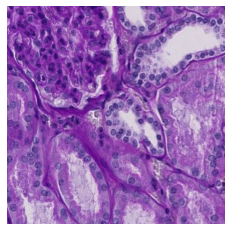

In [27]:
display_tiff(PATH + 'train/0006ff2aa7cd.tif')

There are 7033 files in the **train** directory.

In [28]:
import os
def count_files(directory_path):
    num_files = len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])
    return num_files
train_files = count_files(PATH + 'train')

print(train_files)

7033


Below there is a sample image from the **test** directory.

Format: TIFF
Size: (512, 512)
Mode: RGB

Additional Information:
compression: tiff_lzw
dpi: (1, 1)
resolution: (1, 1)


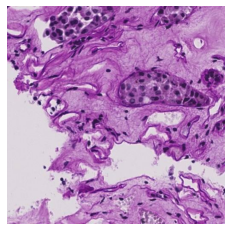

In [29]:
display_tiff(PATH + 'test/72e40acccadf.tif')

There is only 1 image in the **test** directory.

In [30]:
test_files = count_files(PATH + 'test')
print(test_files)

1


## polygons.jsonl
Polygonal segmentation masks in JSONL format, available for Dataset 1 and Dataset 2. Each line gives JSON annotations for a single image with:
### id
Identifies the corresponding image in train/
### annotations
A list of mask annotations with:
### type
Identifies the type of structure annotated:
#### blood_vessel
The target structure. Your goal in this competition is to predict these kinds of masks on the test set.
#### glomerulus
A capillary ball structure in the kidney. These parts of the images were excluded from blood vessel annotation. You should ensure none of your test set predictions occur within glomerulus structures as they will be counted as false positives. Annotations are provided for test set tiles in the hidden version of the dataset.
#### unsure 
A structure the expert annotators cannot confidently distinguish as a blood vessel.
### coordinates 
A list of polygon coordinates defining the segmentation mask.


JSON (JavaScript Object Notation) and JSONL (JSON Lines) are both formats for storing and exchanging data, but they have different structures and use cases:

1. **JSON Format**:
   - In the JSON format, the entire data set is typically enclosed within a single JSON object or array.
   - A standard JSON file might contain an array of objects, each representing a data record, or a single object with nested data.
   - JSON is well-suited for complex data structures with nested arrays and objects.
   - The JSON format is commonly used in web APIs, configuration files, and data interchange between languages that support JSON.
   - Example JSON content:
     ```json
     [
       { "name": "John", "age": 30 },
       { "name": "Jane", "age": 25 }
     ]
     ```

2. **JSONL (JSON Lines) Format**:
   - JSONL format is a variation of JSON where each line is a valid JSON object, separated by newline characters.
   - It's essentially a series of JSON objects, with each object delimited by a newline.
   - This format is particularly useful for handling large datasets, as it allows for processing each line (or JSON object) individually, making it more memory-efficient for large data streams.
   - JSONL is beneficial for streaming applications and log data, where each line can be independently read and processed.
   - Example JSONL content:
     ```jsonl
     { "name": "John", "age": 30 }
     { "name": "Jane", "age": 25 }
     ```

**Key Differences**:
- **Structure**: JSON is a single JSON entity (object or array), while JSONL consists of multiple independent JSON entities separated by newlines.
- **Memory Efficiency**: JSONL can be more memory-efficient for large datasets, as it allows for line-by-line processing.
- **Use Cases**: JSON is widely used for general data interchange, configurations, and APIs. JSONL is more common in streaming data applications, big data processing, and logging.

In summary, while both formats are based on JSON, their structural differences make them suitable for different scenarios and use cases, particularly concerning the size of the data and how it's processed.

Below there is a display of a line from the **polygons.jsonl** file.

In [31]:
import json

# Open the JSONL file and read a single line
with open(PATH + 'polygons.jsonl', 'r') as file:
    line = file.readline()

# Parse the JSON content from that line
json_content = json.loads(line)

# Now json_content holds the data as a Python dictionary
# You can pretty-print this to display its structure
print(json.dumps(json_content, indent=4))

{
    "id": "0006ff2aa7cd",
    "annotations": [
        {
            "type": "glomerulus",
            "coordinates": [
                [
                    [
                        167,
                        249
                    ],
                    [
                        166,
                        249
                    ],
                    [
                        165,
                        249
                    ],
                    [
                        164,
                        249
                    ],
                    [
                        163,
                        249
                    ],
                    [
                        162,
                        249
                    ],
                    [
                        161,
                        249
                    ],
                    [
                        160,
                        249
                    ],
                    [
                      

In the below cell we count all the **annotated** TIFF files in the **train** and **test** directories. Note: there are only 1633 such images, the remaining 5401 TIFF images are not annotated.

In [32]:
import json
with open(PATH + 'polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

print("Count of annotated tiles --", len(tiles_dicts))

Count of annotated tiles -- 1633


The code below show sample mask annotation usage based on data from the **polygons.jsonl** file.

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Coordinate conversion function
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    return coords_array[:, 0], img_height - coords_array[:, 1]

# Global configuration class
class CFG:
    img_path_template: str = PATH + "train/{}.tif"  # Update the path according to your directory structure

# Annotated image plotting function
def plot_annotated_image(image_dict, scale_factor=1.0):
    img = Image.open(CFG.img_path_template.format(image_dict["id"]))
    img = np.array(img)  # Convert to numpy array for matplotlib
    
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed
    plt.imshow(img)

    for annotation in image_dict["annotations"]:
        xs, ys = get_cartesian_coords(annotation["coordinates"], img.shape[0])
        plt.fill(xs, ys, alpha=0.5, label=annotation["type"])  # Set alpha for transparency

    plt.axis('off')  # Hide axes
    plt.title(f'Image ID: {image_dict["id"]}')
    plt.legend()  # Optional: Display legend if needed
    plt.show()

Plot annotated image

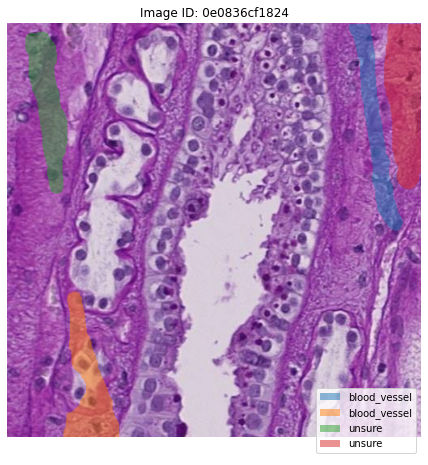

In [34]:
plot_annotated_image(tiles_dicts[100])

## tile_meta.csv 
Metadata for each image. The hidden version of this file also contains metadata for the test set tiles.
### source_wsi 
Identifies the WSI this tile was extracted from.
### {i|j} 
The location of the upper-left corner within the WSI where the tile was extracted.
### dataset 
The dataset this tile belongs to, as described above.


In [35]:
import pandas as pd
tile_meta_df = pd.read_csv(PATH + "tile_meta.csv")
print(tile_meta_df.head())

             id  source_wsi  dataset      i      j
0  0006ff2aa7cd           2        2  16896  16420
1  000e79e206b7           6        3  10240  29184
2  00168d1b7522           2        2  14848  14884
3  00176a88fdb0           7        3  14848  25088
4  0033bbc76b6b           1        1  10240  43008


## wsi_meta.csv 
Metadata for the Whole Slide Images the tiles were extracted from.
### source_wsi 
Identifies the WSI.
### age, sex, race, height, weight, and bmi 
demographic information about the tissue donor.

In [36]:
wsi_meta_df = pd.read_csv(PATH + "wsi_meta.csv")
print(wsi_meta_df.head())

   source_wsi  age sex race  height  weight   bmi
0           1   58   F    W   160.0    59.0  23.0
1           2   56   F    W   175.2   139.6  45.5
2           3   73   F    W   162.3    87.5  33.2
3           4   53   M    B   166.0    73.0  26.5


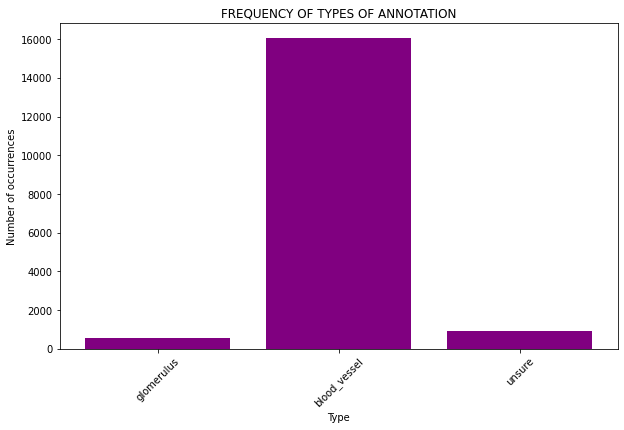

In [37]:
types = [annotation['type'] for polygon in tiles_dicts for annotation in polygon['annotations']]
types_count = Counter(types)

plt.figure(figsize=(10, 6))
plt.bar(types_count.keys(), types_count.values(), color='purple')
plt.title('FREQUENCY OF TYPES OF ANNOTATION')
plt.xlabel('Type')
plt.ylabel('Number of occurrences')
plt.xticks(rotation=45)
plt.show()

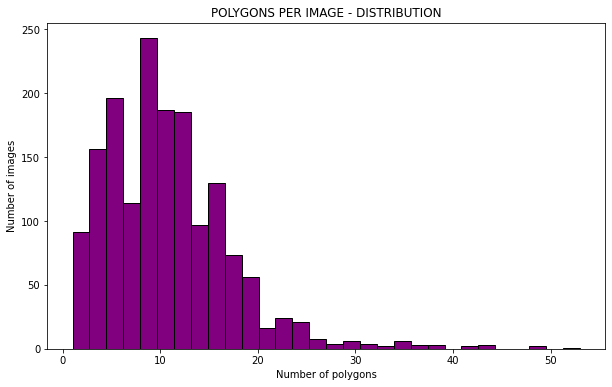

In [38]:
annotations_count = [len(polygon['annotations']) for polygon in tiles_dicts]

plt.figure(figsize=(10, 6))
plt.hist(annotations_count, bins=30, color='purple', edgecolor='black')
plt.title('POLYGONS PER IMAGE - DISTRIBUTION')
plt.xlabel('Number of polygons')
plt.ylabel('Number of images')
plt.show()

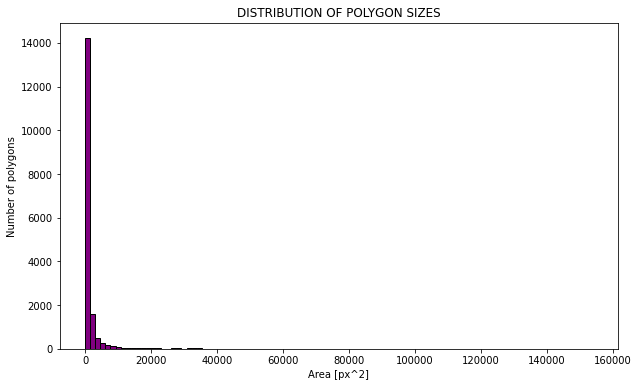

In [39]:
def calculate_polygon_area(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

areas = []

for polygon in tiles_dicts:
    for annotation in polygon['annotations']:
        coords = np.array(annotation['coordinates'][0])
        area = calculate_polygon_area(coords)
        areas.append(area)

plt.figure(figsize=(10, 6))
plt.hist(areas, bins=100, color='purple', edgecolor='black')
plt.title('DISTRIBUTION OF POLYGON SIZES')
plt.xlabel('Area [px^2]')
plt.ylabel('Number of polygons')
plt.show()

In [40]:
area_per_type = defaultdict(list)
for polygon in tiles_dicts:
    for annotation in polygon['annotations']:
        area = calculate_polygon_area(np.array(annotation['coordinates'][0]))
        area_per_type[annotation['type']].append(area)

stats = []
for annotation_type, areas in area_per_type.items():
    stats.append({
        'Typ': annotation_type,
        'Średnia wielkość': np.round(np.mean(areas),2),
        'Odchylenie standardowe': np.round(np.std(areas),2),
        'Mediana': np.round(np.median(areas),2),
    })

stats_df = pd.DataFrame(stats)
stats_df.sort_values('Typ', inplace=True)
stats_df.reset_index(drop=True, inplace=True)
stats_df

,Typ,Średnia wielkość,Odchylenie standardowe,Mediana
0,blood_vessel,1158.96,3274.22,500.5
1,glomerulus,34668.10,31351.34,26173.5
2,unsure,2224.69,4085.71,1036.0


## sample_submission.csv
A sample submission file in the correct format.

The submission.csv file is in a format: id,height,width,prediction_string, where id is the id of the input TIFF file, height and width are 512 and prediction_string is in a format: 0 {confidence} {EncodedMask}. The confidence can have a value between 0 and 1. The binary segmentation masks are run-length encoded (RLE), zlib compressed, and base64 encoded to be used in text format as EncodedMask. Specifically, we use the Coco masks RLE encoding/decoding (see the encode method of COCO’s mask API), the zlib compression/decompression (RFC1950), and vanilla base64 encoding.

## Create sample segmentation mask
The code in the below cell reads the values from the annotations file for a TIFF image, converts these values to corresponding Carthesian coordinates and then draws these annotations on a black background. The annotations are pictured in an analogical way to the one on the corresponding TIFF file, with the only difference being the completely black background. The image produced in this way is then saved to disk under the name "temp_image.png". It will be used in the next step to create segmentation mask.

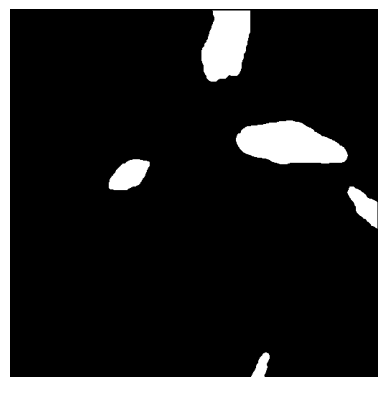

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Coordinate conversion function
def get_cartesian_coords(coords, img_height):
    coords_array = np.array(coords).squeeze()
    return coords_array[:, 0], img_height - coords_array[:, 1]

# Function to plot annotations on a solid background
def plot_annotated_image(image_dict):
    img_width, img_height = 512, 512  # Image resolution
    black_background = np.zeros((img_height, img_width, 3), dtype=np.uint8)

    dpi = 100  # Set the dpi such that one pixel per inch corresponds to the image resolution
    figsize = (img_width / dpi, img_height / dpi)  # Dimensions in inches

    plt.figure(figsize=figsize, dpi=dpi)  # Create a figure with the specified size and resolution
    plt.imshow(black_background, origin='upper')  # Ensure the origin is upper for image orientation

    # Plot each annotation
    for annotation in image_dict["annotations"]:
        xs, ys = get_cartesian_coords(annotation["coordinates"], img_height)
        plt.fill(xs, ys, 'white', edgecolor='none')  # Fill with white color

    plt.axis('off')
    plt.savefig('temp_image.png', dpi=dpi)  # Save the figure as a PNG file
    plt.show()
    
plot_annotated_image(tiles_dicts[102])


### Convert saved image into numpy array
In this step, image created in previous cell will be loaded into the 2D numpy array.

In [42]:
from PIL import Image
import numpy as np

image = Image.open('temp_image.png')
image_array = np.array(image)


The image is stored in RGBA format where the last channel represents the alpha channel (transparency).

In [43]:
image_array.shape

(512, 512, 4)

### Convert RGBA image into binary segmentation mask
 Convert loaded image into the binary segmentation mask using the following method:
- If a (x,y) point is on the edge or within a segment on the mask (which means that at least one of its RGB values is above 0), then the value of this point is True.
-  If the point is outside any annotations, its boolean value is False.

In [44]:
# Convert the image array to a boolean array (ignoring the alpha channel)
non_black_pixels = np.any(image_array[:, :, :3] != [0, 0, 0], axis=-1)

### Binary segmentation mask

In [45]:
non_black_pixels.shape

(512, 512)

In [46]:
non_black_pixels

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### Display binary segmentation mask
Below the binary array named "non_black_pixels" is displayed as a black-and-white image, where the True value corresponds to white and False value corresponds to black. Later the image is displayed and we can see that the white areas are the areas of annotations.

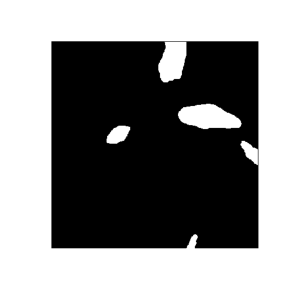

In [47]:
import matplotlib.pyplot as plt

# Assuming 'your_boolean_array' is your 2D boolean array
plt.imshow(non_black_pixels, cmap='gray')  # 'gray' colormap for black and white image
plt.axis('off')  # Turn off the axis to not display ticks and labels
plt.gca().set_position([0, 0, 1, 1])  # Set the axes to fill the figure completely
plt.gca().set_axis_off()  # Ensure no axis is displayed
plt.subplots_adjust(top=1, bottom=0, right=1, left=0,
                    hspace=0, wspace=0)  # Adjust the subplot parameters to make the figure fill the frame
plt.margins(0,0)  # Remove the margins
plt.show()



### Converting a binary mask into OID challenge encoding ascii text
encode_binary_mask is a procedure that converts binary mask into the OID string used in submission file.

In [48]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool_:
    raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)


  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str


### Converting sample binary mask into the OID string

In [49]:
encode_binary_mask(non_black_pixels)

b'eNrV1NuS4jYQBuBXstQigUoq2d2qDAxu2dgYn23A5zPvf5d/p2Z8MZNJbXKRqnDz9S8LY6GWjfkeiNsvZdFZxv/+Mz+35u+RSu3ZLI2zyl5N7IdZG46K7RM3xklFtgsXCm2PO2OiwL5wb4x0sQMejZ48O+TJ6FZdO+bFaMixE34YNZ3slE+i+uDDytgR5epi5eyKgmbowQnjF4wPyD7ygBwg96sph7hP96kJR6Km9oMxx6Khxgo5FR1VVsCZ6KHHuZiosFy+iYVuq4tZCVel1mzW4gx7sxWBiqzW7EWkAqsxBxGrRf0He9b/MZrl9qLivcPl9kHZ3uViu1C8v3K2vVOxv8Mr3fcNp9uYyn0HQ+SJ8633fb7GfJnuL7rcjtDX1XaQw9Pd/LUXw7ZB2ZibRji7CmWn/V34N7Y62EWyf2p0uItl91TraJfI9h9b6XiXyuap1Mkuk/VTodNdLqt/4STOVr5JVHMoNLYH9UX1qDuRWtnGVePhjvHcSjaOmg431IUVbRZaDpkeRGcFm5Eeh0SPYrIum55Oz2ftSt+eVUvOs6M9GdrjSz1xIL+0qiL3eeBIfqtfyppzebiqks7PV66kFb2UKbdS+C9lxINUZ5QNXzmkgjroUUUTp+xSQwvHrya8SBwoHfIoceA0Dp6cydce7vagSDtcS0cl+mGWEgdYz68u5h1eka/you56XM2l/5q/no8j5fT9cXPbP86UosY02z0+bzIV4fFu0rWvx1A51PJdztbtmKqH7NinkAZ+s+cLBTR+4sAjvCC/d8KiPSz6xxx5xvfOf+GE5/DwO2+OHOD+/TsHHnDd/2E/W8+EdXtY98wtnylaXbjBpsX04JodSlZPuuIT/tv3Orrkh8ywuQU2OV/19I0neVu96Cs2/45Nz9E3xWqgMzRDCXPukCPkFjnWKTey+tREJ2iaejXVMbq0gRFyC0PkbjXTAZey/2CufS7kQFc05R3NeUNT3uS0WmgXnbV8sETTZm